In [1]:
from torch.nn import DataParallel
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import chromadb
from chromadb.config import Settings
import pymupdf
import re
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import pandas as pd
import os

# Set environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
dir_path = "/secure/shared_data/rag_embedding_model"

tokenizer = AutoTokenizer.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True, cache_dir=dir_path)
embedding_model = AutoModel.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True, cache_dir=dir_path)

embedding_model.to(device)
embedding_model.half()

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


NVEmbedModel(
  (latent_attention_model): LatentAttentionModel(
    (cross_attend_blocks): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_q): Linear(in_features=4096, out_features=32768, bias=False)
          (to_kv): Linear(in_features=4096, out_features=65536, bias=False)
          (to_out): Linear(in_features=32768, out_features=4096, bias=False)
        )
        (norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (norm_context): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=4096, out_features=32768, bias=True)
            (1): GEGLU()
            (2): Linear(in_features=16384, out_features=4096, bias=True)
          )
        )
        (norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (embedding_model): BidirectionalMistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (la

In [22]:
def load_pdf(files="/home/yl3427/cylab/rag_tnm/selfCorrectionAgent/src/ajcc_7thed_cancer_staging_manual.pdf"):
    if not isinstance(files, list):
        files = [files]  

    documents = []
    for file_path in files:
        doc = pymupdf.open(file_path)
        text = ""
        
        print(f"{len(doc)} pages found in {file_path}")
        for page in doc:
            text += page.get_text()

        text = group_broken_paragraphs(text)
        text = clean_extra_whitespace_within_paragraphs(text)

        document = Document(
            page_content=text,
            metadata={"source": file_path}
        )
        documents.append(document)


    return documents

def clean_extra_whitespace_within_paragraphs(text):
    return re.sub(r'[ \t]+', ' ', text)

def group_broken_paragraphs(text):
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    # text = re.sub(r"\n{2,}", "\n", text)
    return text

In [23]:
def split_documents(
    chunk_size: int,
    knowledge_base,
    tokenizer
):
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        separators = ["\n\n", "\n", '(?<=[.?"\s])\s+'],
        tokenizer=tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=0,
        add_start_index=True,
        strip_whitespace=True,
        is_separator_regex=True
    )

    docs_processed = (text_splitter.split_documents([doc]) for doc in knowledge_base)

    unique_texts = set()
    docs_processed_unique = []
    for doc_chunk in docs_processed:
        for doc in doc_chunk:
            if doc.page_content not in unique_texts:
                unique_texts.add(doc.page_content)
                docs_processed_unique.append(doc)

    return docs_processed_unique

In [24]:
MAX_LENGTH = 512

docs_processed = split_documents(
    chunk_size = MAX_LENGTH, 
    knowledge_base = load_pdf(),
    tokenizer = tokenizer,
)
len(docs_processed)

23 pages found in /home/yl3427/cylab/rag_tnm/selfCorrectionAgent/src/ajcc_7thed_cancer_staging_manual.pdf


69

Maximum sequence length in chunks: 567


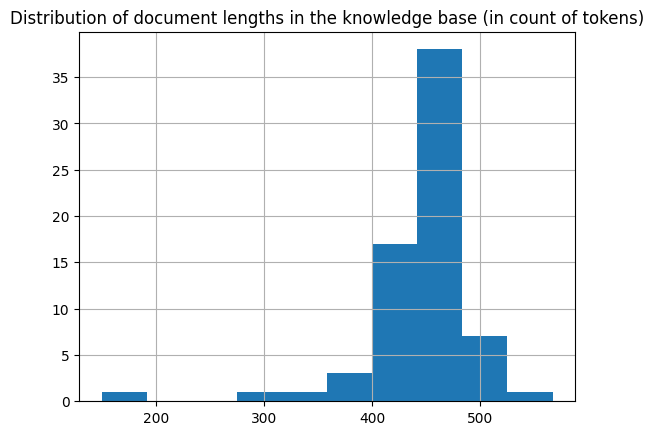

570

In [26]:
def plot_docs_tokens(docs_processed, tokenizer):
    lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]
    print(f"Maximum sequence length in chunks: {max(lengths)}")
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
    plt.show()
    return max(lengths)

MAX_LENGTH = plot_docs_tokens(docs_processed, tokenizer)
MAX_LENGTH = round(MAX_LENGTH, -1)
MAX_LENGTH

In [27]:
def embed_docs_in_chroma(docs, collection, max_length=MAX_LENGTH):
    
    pbar = tqdm(total=len(docs))

    for doc in docs:
        id = str(doc.metadata["start_index"])
        doc_text = doc.page_content

        with torch.no_grad():
            embeddings = embedding_model.encode([doc_text], max_length=max_length)
            embeddings = embeddings.detach().cpu().numpy().tolist()

        collection.add(
            embeddings=embeddings,
            # metadatas=[{}],
            documents=[doc_text],
            ids=[id]
        )
        pbar.update(1)
        torch.cuda.empty_cache()
        
    pbar.close()

In [28]:
client = chromadb.PersistentClient(path="/home/yl3427/cylab/chroma_db",
                                   settings=Settings(allow_reset=True))

brca_collection = client.get_or_create_collection(name = "brca", metadata={"hnsw:space": "cosine"})
brca_collection.count()

0

In [29]:
embed_docs_in_chroma(docs_processed, brca_collection)
brca_collection.count()

  0%|          | 0/69 [00:00<?, ?it/s]/home/yl3427/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/26db444e203771ea231d32a795344655e1119d40/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
100%|██████████| 69/69 [01:55<00:00,  1.67s/it]


69

# RAG - raw chunks

In [30]:
client = chromadb.PersistentClient(path="/home/yl3427/cylab/chroma_db",
                                   settings=Settings(allow_reset=True))

brca_collection = client.get_collection(name = "brca")
brca_collection.count()

69

In [31]:
query_t14 = """You are provided with a pathology report for a breast cancer patient and relevant chunks from the AJCC's TNM Staging System guidelines as context.
Please review this report and determine the pathologic T stage of the patient's breast cancer, with the help of the context.
As you analyze the report, explain step-by-step how you are interpreting the relevant information according to the AJCC guidelines and how it leads to the final decision regarding the T stage. Ignore any substaging information. Please select from the following four options: T1, T2, T3, T4.
"""
query_n03 = """You are provided with a pathology report for a breast cancer patient and relevant chunks from the AJCC's TNM Staging System guidelines as context.
Please review this report and determine the pathologic N stage of the patient's breast cancer, with the help of the context.
As you analyze the report, explain step-by-step how you are interpreting the relevant information according to the AJCC guidelines and how it leads to the final decision regarding the N stage. Ignore any substaging information. Please select from the following four options: N0, N1, N2, N3.
"""
queries = [query_t14, query_n03]

In [32]:
lengths = [len(tokenizer.encode(query)) for query in queries]
lengths

[131, 131]

In [33]:
results = brca_collection.query(query_embeddings=embedding_model.encode(
    queries, max_length=MAX_LENGTH).detach().cpu().numpy().tolist(),
    include=["documents", "distances"],
    n_results=3,
    )

results

{'ids': [['8197', '6623', '63617', '64906', '74670'],
  ['8197', '71316', '69959', '74670', '6623']],
 'distances': [[0.3787946421580234,
   0.3809780981051395,
   0.4006083019694724,
   0.4033960491944447,
   0.4076691735530952],
  [0.385829505440451,
   0.38841106948556725,
   0.40128222121561097,
   0.40742356737337837,
   0.40899991809874836]],
 'metadatas': None,
 'embeddings': None,
 'documents': [['Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Cent

In [34]:
rag_raw_t14 = '\n'.join(results['documents'][0])
rag_raw_n03 = '\n'.join(results['documents'][1])

print(rag_raw_t14)
print()
print(rag_raw_n03)

Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Central portion of breast C50.2 Upper inner quadrant of breast C50.3 Lower inner quadrant of breast C50.4 Upper outer quadrant of breast C50.5 Lower outer quadrant of breast C50.6 Axillary tail of breast C50.8 Overlapping lesion of breast C50.9 Breast, NOS ICD-O-3 HISTOLOGY CODE RANGES 8000–8576, 8940–8950, 8980–8981, 9020 Notes: * T1 includes T1mi. ** T0 and T1 tumors with nodal micrometastases only are exclu

# Long Term Memory (LTM) 

In [35]:
main_query_t14 = '''Please infer a list of general rules that help predict the T stage for breast cancer based on the AJCC's TNM Staging System. Ensure there is at least one rule for each T stage (T1, T2, T3, T4) in the list of rules.'''
main_query_n03 = '''Please infer a list of general rules that help predict the N stage for breast cancer based on the AJCC's TNM Staging System. Ensure there is at least one rule for each N stage (N0, N1, N2, N3) in the list of rules.'''

## vllm

In [59]:
from openai import OpenAI

def agent(prompt):
    client = OpenAI(api_key = "empty",
                base_url = "http://localhost:8000/v1")
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model = "mistralai/Mixtral-8x7B-Instruct-v0.1",
        messages = messages,
        temperature = 0.1)
  
    return response.choices[0].message.content

## 1. ltm_zs

In [37]:
ltm_zs_t14 = agent(main_query_t14)
ltm_zs_n03 = agent(main_query_n03)

print(ltm_zs_t14)
print()
print(ltm_zs_n03)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Sure, I'd be happy to help with that! The American Joint Committee on Cancer (AJCC)'s TNM Staging System is a widely accepted method for staging breast cancer. The "T" in TNM refers to the size of the tumor and its extent of involvement in the breast. Here are some general rules that can help predict the T stage for breast cancer:

* T1: The tumor is 2 centimeters (cm) or less in size. This can be further divided into T1mi (minimal invasion, tumor invades up to 0.1 cm), T1a (tumor invades 0.1 to 0.5 cm), T1b (tumor invades 0.5 to 1 cm), and T1c (tumor invades more than 1 cm but not more than 2 cm).
* T2: The tumor is more than 2 cm but not more than 5 cm in size.
* T3: The tumor is more than 5 cm in size. Alternatively, the tumor may be any size but has extension to the chest wall or skin. This can include inflammatory carcinoma, which is a clinical diagnosis characterized by diffuse erythema and edema of the breast skin.
* T4: The tumor has extension to the chest wall and/or skin, re

## 2. ltm_rag1

In [44]:
rule_generator_prompt = """
You are a helpful assistant. Based on the provided context, answer the question.

Context:
{context}

Question:
{question}
"""
# rule_generator_prompt_debug = """
# You are a helpful assistant. Based on the provided context, answer the question.

# Context:
# {context}

# Question:
# {question}
# When you list rules, add a part of the context that supports each rule.
# """

In [52]:
# context generation
results = brca_collection.query(query_embeddings=embedding_model.encode(
    [main_query_t14, main_query_n03], max_length=MAX_LENGTH).detach().cpu().numpy().tolist(),
    include=["documents", "distances"],
    n_results=2,
    )

context_t14 = '\n'.join(results['documents'][0])
context_n03 = '\n'.join(results['documents'][1])

/home/yl3427/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/26db444e203771ea231d32a795344655e1119d40/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [53]:
results

{'ids': [['8197', '6623'], ['8197', '74670']],
 'distances': [[0.38070543457315864, 0.41135043590538667],
  [0.3556204066343326, 0.3985895845341134]],
 'metadatas': None,
 'embeddings': None,
 'documents': [['Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Central portion of breast C50.2 Upper inner quadrant of breast C50.3 Lower inner quadrant of breast C50.4 Upper outer quadrant of breast C50.5 Lower outer quadrant of breast C50.6 Axillary tail of breast 

In [54]:
print(context_t14)
print()
print(context_n03)

Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Central portion of breast C50.2 Upper inner quadrant of breast C50.3 Lower inner quadrant of breast C50.4 Upper outer quadrant of breast C50.5 Lower outer quadrant of breast C50.6 Axillary tail of breast C50.8 Overlapping lesion of breast C50.9 Breast, NOS ICD-O-3 HISTOLOGY CODE RANGES 8000–8576, 8940–8950, 8980–8981, 9020 Notes: * T1 includes T1mi. ** T0 and T1 tumors with nodal micrometastases only are exclu

In [60]:
ltm_rag1_t14 = agent(rule_generator_prompt.format(context=context_t14, question=main_query_t14))
ltm_rag1_n03 = agent(rule_generator_prompt.format(context=context_n03, question=main_query_n03))

In [61]:
print(ltm_rag1_t14)
print()
print(ltm_rag1_n03)

 Sure, based on the AJCC's TNM Staging System for breast cancer, here are some general rules to help predict the T stage:

1. T1: This stage includes invasive breast carcinomas that are 2 cm or less in size. This can be further divided into T1mi (microinvasion 0.1 cm or less), T1a (0.1 cm but less than 0.5 cm in size), T1b (0.5 cm but less than 1 cm in size), and T1c (1 cm but less than 2 cm in size).

2. T2: This stage includes invasive breast carcinomas that are more than 2 cm but not more than 5 cm in size.

3. T3: This stage includes invasive breast carcinomas that are more than 5 cm in size. It also includes tumors of any size with direct extension to the chest wall or skin.

4. T4: This stage includes invasive breast carcinomas that have spread to the chest wall and/or the skin, resulting in ulceration (T4b) or satellite nodules (T4c), or inflammatory carcinoma (T4d). 

Please note that these are general rules and the actual T stage should be determined by a healthcare profession

In [64]:
print(agent(rule_generator_prompt_debug.format(context=context_t14, question=main_query_t14)))


 Sure, here are the general rules to predict the T stage for breast cancer based on the AJCC's TNM Staging System:

1. T1 Stage:
   - A tumor is ≤ 20 millimeters (mm) in greatest dimension. This includes tumors that are 20 mm or less in size with microinvasion (T1mi). 
   Supporting text: "T1: Tumor ≤ 20 millimeters in greatest dimension."

2. T2 Stage:
   - A tumor is > 20 mm and ≤ 50 mm in greatest dimension.
   Supporting text: "T2: Tumor > 20 millimeters but ≤ 50 millimeters in greatest dimension."

3. T3 Stage:
   - A tumor is > 50 mm in greatest dimension.
   Supporting text: "T3: Tumor > 50 millimeters in greatest dimension."
   OR
   - The tumor has grown into the chest wall.
   Supporting text: "T3: Tumor of any size with direct extension to the chest wall."

4. T4 Stage:
   - The tumor has grown into the chest wall and the skin, with or without an ulcer (includes inflammatory carcinoma).
   Supporting text: "T4a: Tumor of any size with extension to the chest wall."
   "T4b: I

In [68]:
query = '''Do you think the following rules are all correct?



1. T1: This stage includes invasive breast carcinomas that are 2 cm or less in size. This can be further divided into T1mi (microinvasion 0.1 cm or less), T1a (0.1 cm but less than 0.5 cm in size), T1b (0.5 cm but less than 1 cm in size), and T1c (1 cm but less than 2 cm in size).

2. T2: This stage includes invasive breast carcinomas that are more than 2 cm but not more than 5 cm in size.

3. T3: This stage includes invasive breast carcinomas that are more than 5 cm in size. It also includes tumors of any size with direct extension to the chest wall or skin.

4. T4: This stage includes invasive breast carcinomas that have spread to the chest wall and/or the skin, resulting in ulceration (T4b) or satellite nodules (T4c), or inflammatory carcinoma (T4d). 
'''
print(agent(query))

 Yes, these rules accurately describe the T classification system for breast cancer staging as defined by the American Joint Committee on Cancer (AJCC). This system is used to describe the size and extent of the primary tumor and is a component of the overall stage grouping for breast cancer.

* T1: Tumor is 2 cm or less in size
	+ T1mi: Microinvasion 0.1 cm or less
	+ T1a: Tumor is 0.1 cm but less than 0.5 cm in size
	+ T1b: Tumor is 0.5 cm but less than 1 cm in size
	+ T1c: Tumor is 1 cm but less than 2 cm in size
* T2: Tumor is more than 2 cm but not more than 5 cm in size
* T3: Tumor is more than 5 cm in size or tumor of any size with direct extension to the chest wall or skin
* T4: Tumor has spread to the chest wall and/or the skin, resulting in ulceration (T4b) or satellite nodules (T4c), or inflammatory carcinoma (T4d)

It is important to note that this is just one component of the overall staging system and that the final stage is determined by the combination of T, N (lymph no

## 3. ltm_rag2

In [69]:
query_decomposer_prompt = """
You are a helpful assistant that decomposes an input query into multiple sub-queries.
Your goal is to break down the input into a set of specific sub-questions that can be answered individually to cover the full scope of the original question.

Generate at least 5 sub-queries related to the following input query: {question}

"""
rule_generator_prompt = """
You are a helpful assistant. Based on the provided context, answer the question.

Context:
{context}

Question:
{question}
"""

In [71]:
answer = agent(query_decomposer_prompt.format(question=main_query_t14))
print(answer)

 1. What are the general rules for determining T1 stage in the AJCC's TNM Staging System for breast cancer?
2. What are the specific criteria for classifying a breast cancer tumor as T1mi in the AJCC's TNM Staging System?
3. What are the criteria for classifying a breast cancer tumor as T1a, T1b, or T1c in the AJCC's TNM Staging System?
4. What are the general rules for determining T2 stage in the AJCC's TNM Staging System for breast cancer?
5. What are the specific criteria for classifying a breast cancer tumor as T2a, T2b, or T2c in the AJCC's TNM Staging System?
6. What are the general rules for determining T3 stage in the AJCC's TNM Staging System for breast cancer?
7. What are the specific criteria for classifying a breast cancer tumor as T3a or T3b in the AJCC's TNM Staging System?
8. What are the general rules for determining T4 stage in the AJCC's TNM Staging System for breast cancer?
9. What are the specific criteria for classifying a breast cancer tumor as T4a, T4b, T4c, or T

In [72]:
subqueries = answer.split("\n")
subqueries = [subquery.strip() for subquery in subqueries]
subqueries

["1. What are the general rules for determining T1 stage in the AJCC's TNM Staging System for breast cancer?",
 "2. What are the specific criteria for classifying a breast cancer tumor as T1mi in the AJCC's TNM Staging System?",
 "3. What are the criteria for classifying a breast cancer tumor as T1a, T1b, or T1c in the AJCC's TNM Staging System?",
 "4. What are the general rules for determining T2 stage in the AJCC's TNM Staging System for breast cancer?",
 "5. What are the specific criteria for classifying a breast cancer tumor as T2a, T2b, or T2c in the AJCC's TNM Staging System?",
 "6. What are the general rules for determining T3 stage in the AJCC's TNM Staging System for breast cancer?",
 "7. What are the specific criteria for classifying a breast cancer tumor as T3a or T3b in the AJCC's TNM Staging System?",
 "8. What are the general rules for determining T4 stage in the AJCC's TNM Staging System for breast cancer?",
 "9. What are the specific criteria for classifying a breast ca

In [73]:
results = brca_collection.query(query_embeddings=embedding_model.encode(subqueries, max_length=MAX_LENGTH).detach().cpu().numpy().tolist(),
                                                    include=["metadatas", "documents", "distances"],
                                                    n_results=2,
                                                    )

results

/home/yl3427/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/26db444e203771ea231d32a795344655e1119d40/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


{'ids': [['6623', '8197'],
  ['97158', '6623'],
  ['8197', '6623'],
  ['6623', '11287'],
  ['8197', '11287'],
  ['6623', '8197'],
  ['8197', '6623'],
  ['6623', '8197'],
  ['6623', '8197'],
  ['11287', '8197'],
  ['6623', '11287'],
  ['6623', '8197']],
 'distances': [[0.4259810183578404, 0.4446615432751976],
  [0.3797847552285173, 0.41548979680414433],
  [0.4219770116622841, 0.4339409677363867],
  [0.43351378782912264, 0.4416555910016826],
  [0.4478418064480554, 0.4617917987094833],
  [0.4195603749285234, 0.4347584469487624],
  [0.41844691034768755, 0.4348006217097409],
  [0.3937680132930528, 0.43051555261952124],
  [0.40607333345345253, 0.41147266619112244],
  [0.4189710170968435, 0.4337464643278973],
  [0.4179052646973067, 0.4181356717369664],
  [0.4292932930949548, 0.4430581417754035]],
 'metadatas': [[None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, N

In [74]:
retrieved_context = ""
id_set = set()
for query in range(len(results['documents'])):
    # print(f"For {query}st query: ")
    for top in range(len(results['documents'][query])):
        if results['ids'][query][top] in id_set:
            print(f"Skip at {query}, {top}")
            continue
        else:
            id_set.add(results['ids'][query][top])
            retrieved_context += results['documents'][query][top]+"\n"
            print(f"Add at {query}, {top}")

Add at 0, 0
Add at 0, 1
Add at 1, 0
Skip at 1, 1
Skip at 2, 0
Skip at 2, 1
Skip at 3, 0
Add at 3, 1
Skip at 4, 0
Skip at 4, 1
Skip at 5, 0
Skip at 5, 1
Skip at 6, 0
Skip at 6, 1
Skip at 7, 0
Skip at 7, 1
Skip at 8, 0
Skip at 8, 1
Skip at 9, 0
Skip at 9, 1
Skip at 10, 0
Skip at 10, 1
Skip at 11, 0
Skip at 11, 1


In [76]:
print(retrieved_context)

The registrars are requested to describe how they deﬁ ned response [by physical examination, imaging tech- niques (mammogram, ultrasound, magnetic resonance imaging (MRI)) or pathologically] ● Patients will be considered to have M1 (and therefore Stage IV) breast cancer if they have had clinically or radiographically detectable metastases, with or without biopsy, prior to neoadjuvant systemic therapy, regardless of their status after neoadjuvant systemic therapy In order to view this proof accurately, the Overprint Preview Option must be set to Always in Acrobat Professional or Adobe Reader. Please contact your Customer Service Representative if you have questions about finding this option. Job Name: -- /381449t Breast 349 32 INTRODUCTION This staging system for carcinoma of the breast applies to inva- sive (also designated inﬁ ltrating) as well as in situ carcinomas, with or without microinvasion. Microscopic conﬁ rmation of the diagnosis is mandatory, and the histologic type and grad

In [78]:
ltm_rag2_t14 = agent(rule_generator_prompt.format(context = retrieved_context, question = main_query_t14))
print(ltm_rag2_t14)

 Based on the provided context, here are the general rules that help predict the T stage for breast cancer according to the AJCC's TNM Staging System:

1. T1: This stage includes invasive breast carcinomas that are 2 cm or less in size. It can be further divided into T1a, T1b, and T1c based on the size of the tumor. T1a is for tumors 0.5 cm or less, T1b is for tumors larger than 0.5 cm but not more than 1 cm, and T1c is for tumors larger than 1 cm but not more than 2 cm.

2. T2: This stage includes invasive breast carcinomas that are larger than 2 cm but not more than 5 cm.

3. T3: This stage includes invasive breast carcinomas that are larger than 5 cm. It also includes breast carcinomas of any size with direct extension to the chest wall or skin.

4. T4: This stage includes invasive breast carcinomas that have direct extension to the chest wall and/or skin. T4 can be further divided into T4a, T4b, T4c, and T4d based on the specific extent of the invasion. T4a is for tumors with exten

In [79]:
# n
answer = agent(query_decomposer_prompt.format(question=main_query_n03))
print(answer)

 1. What are the criteria for classifying the size of cancerous lymph nodes in the armpit (axillary nodes) for N0 stage in the AJCC's TNM Staging System for breast cancer?
2. What are the specific rules to determine the N1 stage in the AJCC's TNM Staging System for breast cancer, in terms of the involvement of axillary lymph nodes?
3. Can you outline the criteria for classifying the involvement of axillary lymph nodes and/or internal mammary lymph nodes for the N2 stage in the AJCC's TNM Staging System for breast cancer?
4. What are the detailed requirements for the N3 stage in the AJCC's TNM Staging System for breast cancer, particularly in terms of the number and location of involved lymph nodes?
5. Are there any additional factors, besides the number and location of involved lymph nodes, that might influence the assignment of N stage in the AJCC's TNM Staging System for breast cancer?


In [80]:
subqueries = answer.split("\n")
subqueries = [subquery.strip() for subquery in subqueries]
subqueries

["1. What are the criteria for classifying the size of cancerous lymph nodes in the armpit (axillary nodes) for N0 stage in the AJCC's TNM Staging System for breast cancer?",
 "2. What are the specific rules to determine the N1 stage in the AJCC's TNM Staging System for breast cancer, in terms of the involvement of axillary lymph nodes?",
 "3. Can you outline the criteria for classifying the involvement of axillary lymph nodes and/or internal mammary lymph nodes for the N2 stage in the AJCC's TNM Staging System for breast cancer?",
 "4. What are the detailed requirements for the N3 stage in the AJCC's TNM Staging System for breast cancer, particularly in terms of the number and location of involved lymph nodes?",
 "5. Are there any additional factors, besides the number and location of involved lymph nodes, that might influence the assignment of N stage in the AJCC's TNM Staging System for breast cancer?"]

In [81]:
results = brca_collection.query(query_embeddings=embedding_model.encode(subqueries, max_length=MAX_LENGTH).detach().cpu().numpy().tolist(),
                                                    include=["metadatas", "documents", "distances"],
                                                    n_results=2,
                                                    )

results

/home/yl3427/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/26db444e203771ea231d32a795344655e1119d40/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


{'ids': [['82147', '30009'],
  ['8197', '6623'],
  ['71316', '67023'],
  ['8197', '6623'],
  ['13360', '82147']],
 'distances': [[0.3783628203322358, 0.38248441675223577],
  [0.3894978424824532, 0.4056552650201183],
  [0.36925876793302914, 0.37529702609773496],
  [0.39672623757979386, 0.40486974755925564],
  [0.3870707342380135, 0.4099014703108187]],
 'metadatas': [[None, None],
  [None, None],
  [None, None],
  [None, None],
  [None, None]],
 'embeddings': None,
 'documents': [['Q: Should size criteria be used to distinguish between isolated tumor cells and micrometastases? A: Yes; see “Considerations” below; N category. The deﬁ ni- tion is now based on size, NOT how they were detected. Q: How should RT-PCR be used in the detection of small tumor deposits? A: If collected, it should be collected by the registrar, but not used for staging; see “Considerations” below; N category Q: Should the classiﬁ cation of pathologic lymph node status in node-positive (all nodes with deposits greate

In [82]:
retrieved_context = ""
id_set = set()
for query in range(len(results['documents'])):
    # print(f"For {query}st query: ")
    for top in range(len(results['documents'][query])):
        if results['ids'][query][top] in id_set:
            print(f"Skip at {query}, {top}")
            continue
        else:
            id_set.add(results['ids'][query][top])
            retrieved_context += results['documents'][query][top]+"\n"
            print(f"Add at {query}, {top}")

Add at 0, 0
Add at 0, 1
Add at 1, 0
Add at 1, 1
Add at 2, 0
Add at 2, 1
Skip at 3, 0
Skip at 3, 1
Add at 4, 0
Skip at 4, 1


In [83]:
print(retrieved_context)

Q: Should size criteria be used to distinguish between isolated tumor cells and micrometastases? A: Yes; see “Considerations” below; N category. The deﬁ ni- tion is now based on size, NOT how they were detected. Q: How should RT-PCR be used in the detection of small tumor deposits? A: If collected, it should be collected by the registrar, but not used for staging; see “Considerations” below; N category Q: Should the classiﬁ cation of pathologic lymph node status in node-positive (all nodes with deposits greater than 0.2 mm) patients be changed to reﬂ ect more clearly the prognostic signiﬁ - cance of number of affected nodes? A: It was changed in sixth edition; no change in seventh edition. Q: Should a ﬁ nding of positive internal mammary lymph nodes retain a current classiﬁ cation of N3? A: It was reclassiﬁ ed pN2b in the sixth edition. In the seventh edition, if positive internal mammary lymph nodes are iden- tiﬁ ed in the absence of axillary lymph node positivity, then it is classiﬁ 

In [84]:
ltm_rag2_n03 = agent(rule_generator_prompt.format(context = retrieved_context, question = main_query_n03))
print(ltm_rag2_n03)

 1. N0: No regional lymph node metastases. This means that there is no evidence of cancer in the lymph nodes near the breast after a clinical examination or imaging studies.
2. N1: Metastases to movable ipsilateral level I, II axillary lymph node(s). This indicates that cancer has been found in the underarm lymph nodes and they are still moveable, meaning they are not attached to other structures.
3. N2:
a. Metastases in ipsilateral level I, II axillary lymph nodes that are clinically fixed or matted. This means that the cancer in the underarm lymph nodes has caused them to become attached to other structures.
b. Metastases only in clinically detected ipsilateral internal mammary nodes in the absence of clinically evident axillary lymph node metastases. This indicates that cancer has been found in the lymph nodes near the breast bone but there is no evidence of cancer in the underarm lymph nodes.
4. N3:
a. Metastases in ipsilateral infraclavicular (level III axillary) lymph node(s) wit

# Writing context.json

In [86]:
import json
variables = {
    "rag_raw_t14": rag_raw_t14,
    "rag_raw_n03": rag_raw_n03,
    "ltm_zs_t14": ltm_zs_t14,
    "ltm_zs_n03": ltm_zs_n03,
    "ltm_rag1_t14": ltm_rag1_t14,
    "ltm_rag1_n03": ltm_rag1_n03,
    "ltm_rag2_t14": ltm_rag2_t14,
    "ltm_rag2_n03": ltm_rag2_n03
}

# Write the dictionary to a JSON file
with open('context.json', 'w') as json_file:
    json.dump(variables, json_file, indent=4)

In [87]:
print(rag_raw_t14)
print()
print(rag_raw_n03)
print()
print(ltm_zs_t14)
print()
print(ltm_zs_n03)
print()
print(ltm_rag1_t14)
print()
print(ltm_rag1_n03)
print()
print(ltm_rag2_t14)
print()
print(ltm_rag2_n03)

Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Central portion of breast C50.2 Upper inner quadrant of breast C50.3 Lower inner quadrant of breast C50.4 Upper outer quadrant of breast C50.5 Lower outer quadrant of breast C50.6 Axillary tail of breast C50.8 Overlapping lesion of breast C50.9 Breast, NOS ICD-O-3 HISTOLOGY CODE RANGES 8000–8576, 8940–8950, 8980–8981, 9020 Notes: * T1 includes T1mi. ** T0 and T1 tumors with nodal micrometastases only are exclu

In [88]:
with open("/home/yl3427/cylab/rag_tnm/selfCorrectionAgent/src/context.json", "r") as f:
    context = json.load(f)

rag_raw_t14 = context["rag_raw_t14"]
rag_raw_n03 = context["rag_raw_n03"]
ltm_zs_t14 = context["ltm_zs_t14"]
ltm_zs_n03 = context["ltm_zs_n03"]
ltm_rag1_t14 = context["ltm_rag1_t14"]
ltm_rag1_n03 = context["ltm_rag1_n03"]
ltm_rag2_t14 = context["ltm_rag2_t14"]
ltm_rag2_n03 = context["ltm_rag2_n03"]

In [89]:
print(rag_raw_t14)
print()
print(rag_raw_n03)
print()
print(ltm_zs_t14)
print()
print(ltm_zs_n03)
print()
print(ltm_rag1_t14)
print()
print(ltm_rag1_n03)
print()
print(ltm_rag2_t14)
print()
print(ltm_rag2_n03)

Beginning with that initiative, six editions of the AJCC Staging Manual have been published, in which careful deﬁ nitions of the primary tumor (T), the status of the surrounding lymph nodes (N), and the presence of distant ANATOMIC STAGE/PROGNOSTIC GROUPS Stage 0 Tis N0 M0 Stage IA T1 * N0 M0 Stage IB T0 N1mi M0 T1 * N1mi M0 Stage IIA T0 N1 ** M0 T1 * N1 ** M0 T2 N0 M0 Stage IIB T2 N1 M0 T3 N0 M0 Stage IIIA T0 N2 M0 T1 * N2 M0 T2 N2 M0 T3 N1 M0 T3 N2 M0 Stage IIIB T4 N0 M0 T4 N1 M0 T4 N2 M0 Stage IIIC Any T N3 M0 Stage IV Any T Any N M1 ICD-O-3 TOPOGRAPHY CODES C50.0 Nipple C50.1 Central portion of breast C50.2 Upper inner quadrant of breast C50.3 Lower inner quadrant of breast C50.4 Upper outer quadrant of breast C50.5 Lower outer quadrant of breast C50.6 Axillary tail of breast C50.8 Overlapping lesion of breast C50.9 Breast, NOS ICD-O-3 HISTOLOGY CODE RANGES 8000–8576, 8940–8950, 8980–8981, 9020 Notes: * T1 includes T1mi. ** T0 and T1 tumors with nodal micrometastases only are exclu